In [1]:
# Initial imports
import pandas as pd
import numpy as np
from pathlib import Path
import tensorflow as tf
%matplotlib inline

from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
finviz_url = 'https://finviz.com/quote.ashx?t='
tickers = ['AAPL','MSFT','AMZN','FB','GOOGL','GOOG','TSLA','JPM','JNJ']

news_tables = {}
for ticker in tickers:
    url = finviz_url + ticker

    req = Request(url=url, headers={'user-agent': 'my-app'})
    response = urlopen(req)

    html = BeautifulSoup(response, features='html.parser')
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

In [3]:
parsed_data = []

for ticker, news_table in news_tables.items():
    for row in news_table.findAll('tr'):
        title = row.a.text
        date_data = row.td.text.split(' ')

        if len(date_data) == 1:
            time = date_data[0]
        else:
            date = date_data[0]
            time = date_data[1]

        parsed_data.append([ticker, date, time, title])

df = pd.DataFrame(parsed_data, columns=['ticker', 'date', 'time', 'title'])
df['date'] = pd.to_datetime(df.date).dt.date
df

,ticker,date,time,title
0,AAPL,2021-03-24,05:50PM,How Prince Harry's new job with $1.73B startup...
1,AAPL,2021-03-24,04:19PM,"How Is Tesla Stock Worth $3,000? By Becoming B..."
2,AAPL,2021-03-24,04:16PM,"Facebook and Amazon Unleash Spending, Vault At..."
3,AAPL,2021-03-24,04:15PM,Best Dow Jones Stocks To Buy And Watch In Marc...
4,AAPL,2021-03-24,02:09PM,Intel CEO: 'There is competitive fun going on ...
...,...,...,...,...
895,JNJ,2021-03-12,12:53PM,The Pandemic Proved Their Worth What's Next F...
896,JNJ,2021-03-12,11:25AM,World Health Organization grants emergency use...
897,JNJ,2021-03-12,11:16AM,Johnson & Johnson Single-Shot COVID-19 Vaccine...
898,JNJ,2021-03-12,09:43AM,Biden directs states to make COVID-19 vaccines...


In [4]:
nltk.download('vader_lexicon')

vader = SentimentIntensityAnalyzer()

f = lambda title: vader.polarity_scores(title)['compound']
df['compound'] = df['title'].apply(f)
df['compound']

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


0      0.6124
1      0.2263
2      0.1027
3      0.6369
4      0.6124
        ...  
895    0.2263
896   -0.1779
897   -0.1531
898    0.0000
899    0.4767
Name: compound, Length: 900, dtype: float64

In [5]:
plt.figure(figsize=(10,8))
mean_df = df.groupby(['ticker', 'date']).mean().unstack()
#mean_df = df.groupby(['ticker', 'date']).mean().unstack().dropna(axis='columns', thresh=7)
mean_df

compound                        ...                                 
date   2021-03-01 2021-03-02 2021-03-03  ... 2021-03-22 2021-03-23 2021-03-24
ticker                                   ...                                 
AAPL          NaN        NaN        NaN  ...   0.181854   0.096233   0.229095
AMZN          NaN        NaN        NaN  ...   0.187553   0.076230   0.133630
FB            NaN        NaN        NaN  ...   0.054127  -0.183058  -0.017262
GOOG          NaN        NaN        NaN  ...   0.046596   0.034300  -0.030786
GOOGL         NaN        NaN        NaN  ...   0.046596   0.034300  -0.030786
JNJ           NaN        NaN        NaN  ...   0.164162   0.112373   0.150560
JPM       0.36755     0.3612   0.209114  ...   0.168433   0.125680  -0.047650
MSFT          NaN        NaN        NaN  ...  -0.061570  -0.124033   0.003089
TSLA          NaN        NaN        NaN  ...   0.116989   0.000119   0.034237

[9 rows x 23 columns]

<Figure size 720x576 with 0 Axes>

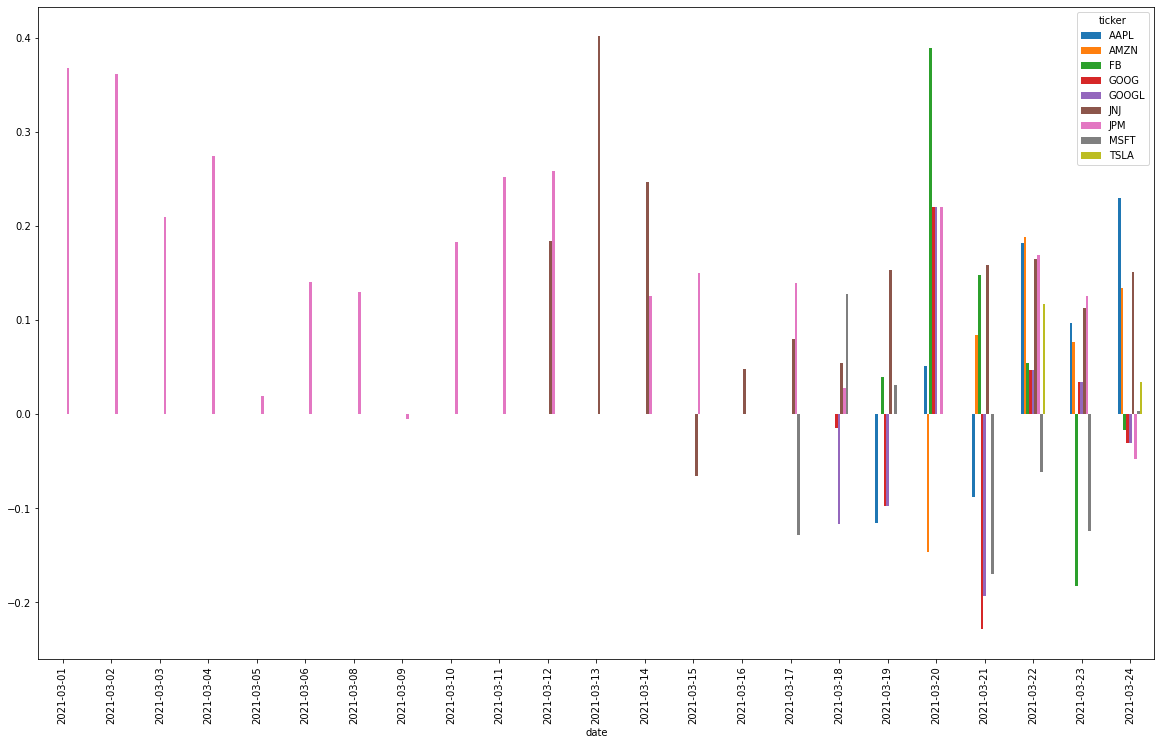

In [6]:
mean_df = mean_df.xs('compound', axis="columns").transpose()
mean_df.plot(kind='bar', figsize=(20, 12))
plt.show()

In [8]:
df2 =(df.groupby(['ticker', 'date']).mean())
df2

compound
ticker date                
AAPL   2021-03-19 -0.115688
       2021-03-20  0.051392
       2021-03-21 -0.087887
       2021-03-22  0.181854
       2021-03-23  0.096233
...                     ...
MSFT   2021-03-23 -0.124033
       2021-03-24  0.003089
TSLA   2021-03-22  0.116989
       2021-03-23  0.000119
       2021-03-24  0.034237

[74 rows x 1 columns]

In [9]:
def score(row):
    if row['compound'] > 0.05:
        signal = 1
    elif row['compound'] < -0.05:
        signal = -1
    else:
        signal = 0     
    return signal


df2['Signal'] = df2.apply(score, axis=1)
df2['Action'] = ["Buy" if x == 1 else "Sell" if x== -1 else "Hold" for x in df2['Signal']] 
df2

compound  Signal Action
ticker date                               
AAPL   2021-03-19 -0.115688      -1   Sell
       2021-03-20  0.051392       1    Buy
       2021-03-21 -0.087887      -1   Sell
       2021-03-22  0.181854       1    Buy
       2021-03-23  0.096233       1    Buy
...                     ...     ...    ...
MSFT   2021-03-23 -0.124033      -1   Sell
       2021-03-24  0.003089       0   Hold
TSLA   2021-03-22  0.116989       1    Buy
       2021-03-23  0.000119       0   Hold
       2021-03-24  0.034237       0   Hold

[74 rows x 3 columns]

In [10]:
df2.to_csv('signal_action.csv')